## Deadline

Wednesday, November 22, 2017, 11:59PM

## Important notes

- When you push your Notebook to GitHub, all the cells must already have been evaluated.
- Don't forget to add a textual description of your thought process and of any assumptions you've made.
- Please write all your comments in English, and use meaningful variable names in your code.

## Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

#### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

#### 3. A propsensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

#### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?


#### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


#### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?


___
___
___

Importing the libraries we will need for the homework

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict,cross_val_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score 
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from scipy import sparse

import itertools

%matplotlib inline

## Question 1: Resolution

### Thought process and Implementation plan:
The objective of this exercise is to analyze the effect of a training program on an individual's earnings. 

** Loading and Cleaning the Dataset ** 

The dataset is provided in a csv file containing the suss-mentioned categories : 
- *treat* : whether the subject followed the tranining program, binary value
- *age* : the age of the subject
- *educ* : the number of years of education 
- *race* : Black, White or Hispanic
- *married* : whether the subject is married or not, binary value
- *nodegree* : whether the subject has a degree (1 if they don't, 0 if they do)
- *re74*, *re75* and *re78*: earnings for the given year

The dtypes and unique values of the columns were verified to make sure that there weren't any suprises along the way. 

When looking at the data we noticed that there wasn't a white column. This column was added manually and individuals were set to 1 if they were neither black nor hispanic. We also added a race column which would take values B,H,W whether the person was black, hispanic or white.

**1. Naive Analysis**

The objective here was to quickly assess whether having followed the training program had an influence on the salary. Therefore we wanted to compare simply the *re78* for people with and without treatment. For that we used the groupby functionality. To obtain statistical information we used the describe functionality of the dataframes and computed the correlation between having taken the treatment and the salary. We plotted the histograms of the data with treatment, without treatment and overall with a boxplot to explicit certain statistical aspects of the data. We also plotter the boxplots of with and without treatment against one another with a swarmplot to determine where the datapoints lie. All of this was done with multiple functions so that they can be reused in following questions


**2. Closer Look **

We conducted similar tests but with all the features this time combining visualization of multiple boxplots with descriptions of all the variables, notably the categorical ones which required slightly different handling 


**3. Propensity Score Model**

Using the cleaned data we can now determine the propensity score, which is to say the probability of receiving treatment given the pre-treatment features. This is done using logistic regression as shown during the Tutorial : 
1. Create feature vectors with dummy
2. Normalize the feature vectors
3. Create the logistic regression model
4. Get the predictions
5. Threshold to get estimate labels
6. Compute the confusion matrix to assess quality of the regression

**4. Balancing the Dataset Via Matching**

In order to do the feature matching, and following the recommendation to use networkx, we first needed to create a connected graph from our observations : 
1. Create a bipartite graph 
2. Add edges between the nodes from the different partitions using the differences in propensity scores from the previous question
3. Used the networkx max_weight_matching algorithm on the bipartite graph in order to find the optimal pairs.

We then observed the feature distributions for the new dataframe containing only the matched pairs. 

**5. Balancing Groups Further**


**6. A Less Naive Analysis**



___
___
___




### 1.0 Loading the Dataset


In [ ]:
# Loading the csv file
data = pd.read_csv("lalonde.csv")

# Adding the white column
data['white'] = (data["black"] + data["hispan"]<1).astype(int)

# Adding a "race" column
data['race'] = "unknown"
data.loc[data["white"] ==1, 'race'] = "W"
data.loc[data["hispan"] ==1, 'race'] = "H"
data.loc[data["black"] ==1, 'race'] = "B"

#Setting the index to the user id
data.set_index("id", inplace = True)

data.head(10)

Functions used for analysis 
** ADD EXPLANATIONS**

In [ ]:
def normal_distribution_test(data):
    k2, p = scipy.stats.normaltest(data)
    if p>0.05:
        print("\tThe null hypothesis cannot be rejected\n")
        return False
    else :
        print("\tThe null hypothesis can be rejected\n")
        return True

def same_distribution_test(data1, data2):
    stats, p = scipy.stats.kruskal(data1, data2)
    if p>0.05:
        print("\tThe null hypothesis cannot be rejected\n")
        return False
    else :
        print("\tThe null hypothesis can be rejected\n")
        return True

def statistical_description(df, col):

    print("Testing whether the entire data is normally distributed")        
    all_normal = normal_distribution_test(list(df[col]))
    
    print("Testing whether the results with treatment are normally distributed")        
    treat_normal = normal_distribution_test(list(df.loc[df['treat'] == 1, col]))
    
    print("Testing whether the results without treatment are normally distributed")        
    no_treat_normal = normal_distribution_test(list(df.loc[df['treat'] == 0, col]))
       
    print("Testing whether the data comes from the same distributions")
    same_distribution_test(list(df.loc[df['treat'] == 0, col]),\
                           list(df.loc[df['treat'] == 1, col]))
    
    print("Computing correlation between Treatment and {}".format(col))
    # Taking into account whether the data is normally distributed or not
    # to select the correlatoin type
    if all_normal or (treat_normal and no_treat_normal):
        corr_type = "pearson"   
    else:
        corr_type = "spearman"

    correlation = df[[col, "treat"]].corr(corr_type)
    print("\t{} correlation between treatment and {} : {:4f}".format(corr_type, col, correlation.loc["treat", col]))

def histogram_boxplot(df, col, title):
    x = list(df[col])
    ax = sns.distplot(x)
    ax2 = ax.twinx()
    sns.boxplot(x=x, ax=ax2)
    ax2.set(ylim=(-.5, 10))  
    ax.set_xlabel(col)
    ax.set_ylabel("percentage")
    ax.set_title(title)

def categorical_boxplots(df, col, year):
    x = 're'+ year
    data = df.copy()
    data[col] = data[col].astype('category')
    if len(data[col].unique()) < 4:
        fig, axs = plt.subplots(1,len(data[col].unique()), figsize=(10,3))

        for i, categ in enumerate(data[col].unique()):
            categ_data = data.loc[data[col] == categ]
            axs[i].set_title(categ)
            axs[i].set_xlim(0,61000)
            try:
                ax = sns.boxplot(x=x, y="treat", ax=axs[i], data=categ_data, orient="h")
                ax = sns.swarmplot(x=x, y="treat", ax=axs[i], data=categ_data, color=".25", orient="h")
                
            except:
                data[col] = data[col].cat.codes
                ax = sns.boxplot(x=x, y="treat", ax=axs[i], data=categ_data, orient="h")
                ax = sns.swarmplot(x=x, y="treat", ax=axs[i], data=categ_data, color=".25", orient="h")

def boxplot_with_swarmplot(df,col):
    data = df.copy()
    data[col] = data[col].astype('category')
    try:
        ax = sns.boxplot(x=col, y="treat", data=data, orient="h")
        ax = sns.swarmplot(x=col, y="treat", data=data, color=".25", orient="h")
    except:
        data[col] = data[col].cat.codes
        ax = sns.boxplot(x=col, y="treat", data=data, orient="h")
        ax = sns.swarmplot(x=col, y="treat", data=data, color=".25", orient="h")
        
def plotting_data(df, col):
    plt.figure(figsize=(10, 10))
    
    # Histograms with boxplots and distribution
    plt.subplot(2,2,1)
    histogram_boxplot(df.loc[df["treat"] == 1], col, "With Treatment")
    
    plt.subplot(2,2,2)
    histogram_boxplot(df.loc[df["treat"] == 0], col, "Without Treatment")
    
    plt.subplot(2,2,3)
    histogram_boxplot(df, col, "With and Without Treatment")
    
    # Boxplots with datapoints
    plt.subplot(2,2,4)
    boxplot_with_swarmplot(df,col)
    
    plt.tight_layout()
    
def compare_distributions_of_feature(df,col, year = "78"):
    data = df.copy()
    data[col] = data[col].astype('category')
    
    if len(data[col].unique()) < 4:
        categorical_boxplots(df, col, year)
    else:
        boxplot_with_swarmplot(df,col)
    
    plt.tight_layout()
    
def plot_all_for_non_categorical_variables(df):
    plt.figure(figsize=(10, 10))

    for idx,col in enumerate(["age", "educ","re74","re75","re78"]):
        if col in ["age", "educ"]:
            plt.subplot(4,2,idx+1)
        else:
            plt.subplot(4,1,idx)
            plt.xlim(0,61000)
        boxplot_with_swarmplot(df,col)

    plt.tight_layout()
    
def plot_distributions(df):
    fig = plt.figure(figsize = (10,10))
    for i, attribute in enumerate(["married", "nodegree", "black", "white", "hispan"]):
        ax = plt.subplot(3,3,i+1)


        ax.hist([df.loc[df_matched[attribute] == 1, "treat"],\
                 df.loc[df_matched[attribute] == 0, "treat"]], color=['r','b'], alpha=0.5)  
        ax.set_title(attribute)
        ax.legend(["Treated", "Not Treated"])
    plt.tight_layout;

**Functions used for computation and visualization of the confusion matrices**

Code taken from [here](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html) for visualization of the confusion matrix


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, print_cnf = False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    if print_cnf:
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Function used to compute all the attributes of the confusion matrix as well as the true positive rates, false positive rates, precision, recall and F1 measure. The function also calls the plotting function above. Note that the function uses the weighted option for precision, recall and f1 score to take into account the fact that the classes are imbalanced.

In [ ]:
def my_confusion_matrix(y_test, y_est, classes, print_cnf = True):    
    # Computing the confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_est);
    # Displaying the values 
    if print_cnf:
        print(cnf_matrix)
    # Plotting the confusion matrix
    plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,
                          title='Normalized confusion matrix', print_cnf = print_cnf);
    # Outputting the TPR, FPR, Precision, Recall, F1
    TPR = cnf_matrix[0,0]/len(prop_data)
    FPR = cnf_matrix[1,0]/len(prop_data)
    precision = precision_score(y_test, y_est, average='weighted')
    recall = recall_score(y_test, y_est, average='weighted')
    F1 = f1_score(y_test, y_est, average='weighted')
    print("--------------------------")
    print("True Positive Rate: {:.4f}".format(TPR))
    print("False Positive Rate: {:.4f}".format(FPR))
    print("Precision : {:.4f}".format(precision))
    print("Recall : {:.4f}".format(recall))
    print("F1 Score: {:.4f}".format(F1))

### 1.1. Naive Analysis

** Raw Data **

We started by recovering certain non parametric metrics regarding the raw data and plotting the correponding boxplots

In [ ]:
statistical_description(data, "re78")

print("Describing the data with parametric and non parametric metrics")
data[["re78", "treat"]].groupby("treat").describe()

In [ ]:
plotting_data(data, "re78")


**Looking at the data description and boxplot :**

Given the average revenues it would even seem that following the training program actually has a negative impact. Looking at the boxplot it would even seem that a larger portion of people suffer from lower salaries (looking at the difference between q3 and q1). However there are certain outlyers with significantly higher salaries when having followed the training program. This may be that there are certain people which benefitted significantly from the traning program.

**Looking at the histograms **

It is evident that a significant number of people do not have a job. This could potentially be biasing the results. We can also note that the distributions are not normal which can also be seen in the statistical tests where the null hypothesis is rejected when testing normality

**Looking at the statistical results :**

Both treatment and no treatment come from the same distribution. This could indicate that there is no difference between having taken the treatment or not. To compute the correlation we must use a non parametric correlation method such as the spearman correlation. This correlation is quite low (-0.04) which would indicate that there is no link between the revenue in 78 and having followed the training program. 

### 1.2. Closer Look

**TODO : For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers. As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.
What do you observe? Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.**

**Questions for TAS : **
- Do we need to describe all the data with plots AND numbers? Or is one or the other sufficient. Especially since the boxplots are explicit enough 

**To Adrian and Jordi : do either of you have any ideas of what else can be visualized?**

**Visualising boxplots for different non categorical features**

In [ ]:
plot_all_for_non_categorical_variables(data)

Certain comments can already be made regarding the different features observed. In nearly all cases, the data is not normally distributed which is why it is important to consider non parametric metrics. That is why the boxplots are ideal to get a broad sense of what is going on in the data. Note that there may be a slight exception where the number of years of education is concerned though which seem to be part of the same distribution.

**TODO : run the test numerically to validate that the ages are part of the same distribution and that it is normally distributed**

More specifically :
- In terms of age, the majority of people interviewed are below their 30s. The same goes for the number of people who did the training. 
- In terms of education, the majority of people interviewed are around 10 years of education. The same goes for the people who did the training. 
- Where the revenues are concerned
    - There are a significant number of people who had 0 revenue in the given years. This means that there are people who are unemployed throughout the entire period which is not suprising in the sense that there is a majority of people under 30 who are being interviewed. This means that at the time of treatment, most of them are most likely still studying and not looking for jobs. 
    - The control group experienced a general decrease in revenue between 74 and 75. This is most likely due to the oil crisis which experienced it's first peak around that time ([see here](https://en.wikipedia.org/wiki/1970s_energy_crisis#/media/File:Nominalrealoilprices1968-2006.png)). Their revenues increased significantly by 78 even though they had not participated in the training program. This could also be linked to a drop in the oil prices before the peak in the 80s.
    - Those who followed the training program essentially had revenues below 3000 dollars in 74 and 75. This is coherent with the fact that a majority of these people are young as mentioned previously and not necessarily looking for jobs. Therefore it would be logical to assume that in 78 when a larger fraction of people got jobs that their revenues would increase but that they would be lower than that of the control group where more people had jobs to begin with, especially since the salary is supposed to increase over time.
    - The outlyers we can see in the treatment group were already present in 74 and 75. 

** Race **

In [ ]:
for year in ["74", "75","78"]:
    compare_distributions_of_feature(data,"race", year = year)

** Married **

In [ ]:
for year in ["74", "75","78"]:
    compare_distributions_of_feature(data,"married", year = year)

**No Degree**

In [ ]:
for year in ["74", "75","78"]:
    compare_distributions_of_feature(data,"nodegree", year = year)

**Getting information for categorical values regarding the treatment**

In [ ]:
for idx,col in enumerate(["married", "nodegree", "race"]):
    description = data[[col, "treat"]].groupby(col).describe()
    print(description["treat"].drop(["min", "25%", "50%", "75%", "max"],axis = 1))  
    print("-----------------------------------")

Looking at how many people followed the seminar we can quickly see that none of the treatment vs. no treatment for the different categories are balanced neither in terms of count, average or distribution. This is something that will be addressed in part 4 of the exercise when matching. 

### 1.3. Propensity Score Model

Function used to compute the propensity scores 

In [ ]:
def propensity_scores(df):
    treatment_features = ['age', 'black', 'white', 'hispan', 'educ', 'married', 'nodegree', 're74', 're75']
    treatment_class = 'treat'

    # The features vector
    X = pd.get_dummies(df[treatment_features])
    X.head(10)
    # The labels
    y = df[treatment_class]
    # The model
    logistic = LogisticRegression()
    # Fit the model to the data
    logistic.fit(X, y)
    # Predictions 
    pred = logistic.predict_proba(X)

    # Saving predictions to dataframe
    df["Probability of Treatment"] = pred[:,1]
    df["Estimated Treatment"] = np.where(df["Probability of Treatment"]>=0.5, 1, 0)

    return pred, y, df

In [ ]:
prop_data = data.copy()
prop_data.reset_index(inplace = True)

treated = prop_data[prop_data['treat']==1]
control = prop_data[prop_data['treat']==0]

print("Treated {0}, Not Treated {1}".format(len(treated), len(control)))

As mentioned previously the classes are imbalanced which will be adressed in the next question 

In [ ]:
pred, labels, prop_data = propensity_scores(prop_data)
# Computing the confusion matrix
my_confusion_matrix(y, prop_data["Estimated Treatment"].tolist(), ["treatment", "control"])


Looking at the normalized confusion matrix for the prediction labels we can see that with a simple non optimized threshold of 0.5 we can already obtain a realtively good estimation of whether a person was going to follow the training program or not. 

**Lookup how to read the confusion matrices again, especially in the case of unbalanced classes**

### 1.4. Balancing the Dataset Via Matching

http://jfinkels-networkx.readthedocs.io/en/latest/reference/algorithms/generated/networkx.algorithms.matching.max_weight_matching.html

In [ ]:
def bipartite_matching(labels, pred):
    # Create a bipartite graph from the weighted adjacency matrix
    G=nx.Graph()

    idx_0 = [i for i in range(len(labels)) if labels[i] == 0] # not treated
    idx_1 = [i for i in range(len(labels)) if labels[i] == 1] # treated

    G.add_nodes_from(idx_0, bipartite=0) 
    G.add_nodes_from(idx_1, bipartite=1)

    # Adding the edges to the graph as the difference in propensity score
    for i in idx_0:
        for j in idx_1:
            G.add_edge(i,j,weight=1/((pred[i,1]-pred[j,1])**2+10**(-10)))

    # Use the networkx max_weight_matching algorithm on the graph in order 
    # to find the optimal pairs.
    matching = nx.max_weight_matching(G)

    # Removing permutations 
    new_matching = [[k,v] for k, v in matching.items()]
    new_matching = dict(set(tuple(sorted(pair)) for pair in new_matching))

    return new_matching

In [ ]:
new_matching = bipartite_matching(y, pred)

In [ ]:
df_matched.loc[[list(new_matching.keys())[5],list(new_matching.values())[5]]]


Retaining only the matched pairs

In [ ]:
df_matched = data.reset_index()
df_matched = df_matched.loc[ list(new_matching.keys()) + list(new_matching.values())]
df_matched.head()

**Observing the distribution of the classes for categorical variables**

In [ ]:
plot_distributions(df_matched)

Observing the distribution of the different variables we see that there is a big imbalance where the hispanics are concerned. 

**Observing the output for the year 1978**

In [ ]:
plotting_data(df_matched, "re78")

In [ ]:
plot_all_for_non_categorical_variables(df_matched)

### 1.5. Balancing Groups Further


**Standardizing the data**

In [ ]:
stand_data = data.copy()
stand_data.drop(["race"], axis = 1, inplace = True)
scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(stand_data) 
stand_data.loc[:,:] = scaled_values
stand_data["white"] = 10*stand_data["white"]
stand_data["black"] = 10*stand_data["black"]
stand_data["hispan"] = 10*stand_data["hispan"]
stand_data["treat"] = data["treat"]

**Computing the New Propensity Scores**

In [ ]:
stand_pred, stand_labels, stand_df = propensity_scores(stand_data)
# Computing the confusion matrix
my_confusion_matrix(stand_labels, stand_df["Estimated Treatment"].tolist(), ["treatment", "control"])

**Matching**

In [ ]:
new_stand_matching = bipartite_matching(stand_labels, stand_pred)
stand_df_matched = data.reset_index()
stand_df_matched = stand_df_matched.loc[ list(new_stand_matching.keys()) + list(new_stand_matching.values())]
plot_distributions(stand_df_matched)


In [ ]:
temp = stand_df_matched.copy()
categs = ["treat", "age", "educ", "married", "nodegree","re74", "re75", "black", "white", "hispan"]
temp1 = temp.loc[list(new_stand_matching.keys()),categs]                        
temp2 = temp.loc[list(new_stand_matching.values()), categs]

temp1.reset_index(inplace = True)       
temp2.reset_index(inplace = True)  

diff = temp1-temp2
diff.drop("index", axis = 1, inplace = True)
diff


___
___
___

## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

2. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.

___
___
___

**1. Loading the dataset **

We started by importing the news groups dataset for the scikit learn library. We isolated the data and the target names then we computed the term frequency inverse document frequency for each of the entries. This becomes our matrix of features X. We then split the dataset into training, validation and testing set using `np.split` function. We were careful to have a sparse array at the end in order to speed up the classification with the random forests. It is important to note that there are 170'000 features for 18'000 samples. Therefore it would have been interesting to do a preliminary feature selection before classification.

**2. Training and Classification With Random Forests **

To find the best parameters we ran a grid search as asked, although it would have been faster to run a random search using the scikit learn RandomSearchCV. We chose not to use the GridSearchCV function because the grid search Cv function outputs the solution with the best results while there is often a tradeoff to be made between the number of parameters / computation time and the accuracy. We wanted to be able to select the set of parameters which offered the best compromise which is why we output the results of the grid search in the form of a heatmap before finding the best tradeoff. We then retrained the model with the optimal parameters, did the confusion matrix and assessed the results as well as the features selected.


### 1. Loading the Dataset

In [2]:
# Load the entire dataset from the website with shuffled ordering
newsgroups = fetch_20newsgroups(subset = "all")
newsgroups.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR', 'description'])

In [3]:
# Computing the features 
vectorizer = TfidfVectorizer(use_idf=True)
X = vectorizer.fit_transform(newsgroups["data"])
# Labels
Y = newsgroups.target
# Mapping the indexes of targets to the names
targets_dict = {i:newsgroups['target_names'][i] for i in range(len(newsgroups['target_names']))}

As the data is already shuffled when loading with the fetching function, we can simply slice the arrays without randomizing the data first.

In [4]:
# Splitting the data into a training, testing and validation set
total = len(Y)
prop = int(np.ceil(0.1*len(Y)))
# Split the training data and the labels 
X_train, X_valid, X_test = np.split(X.toarray(), [total-2*prop, total-prop])
y_train, y_valid, y_test = np.split(Y, [total-2*prop, total-prop])

# Verifying the proportions for the training, validation and testing sets
print(len(X_train)/total, len(X_valid)/total, len(X_test)/total)

# Convert to sparse matrices
X_train, X_valid, X_test = sparse.csc_matrix(X_train), sparse.csc_matrix(X_valid), sparse.csc_matrix(X_test)

0.7999575506738831 0.10002122466305848 0.10002122466305848


### 2. Training and Classification With Random Forests

First a functions which are useful for the question :
- train the random forest classifier model given a training set, the desired number of estimators and the max depth
- test the given model on a given test set and output the accuracy
- run a grid serach on a training and testing set for a given range of estimators and max_depth parameters.

In [5]:
def train_model(X_train, y_train, num_estimators, max_depth):
    rf = RandomForestClassifier(n_estimators=num_estimators, max_depth = max_depth,\
                                random_state = 0)
    rf.fit(X_train, y_train)
    return rf

def test_model(X_test, y_test, rf):
    predicted = rf.predict(X_test)
    accuracy = accuracy_score(y_test, predicted)
    return predicted, accuracy

def grid_search(estimators, depth, step, X_train, y_train, X_test, y_test):
    accuracy_scores = dict()
    accuracy_mat = np.zeros((max_num_est//step,max_num_depth//step))
    
    for n, n_estimators in enumerate(estimators):
        for md, max_depth in tqdm(enumerate(depth)):
            rf = train_model(X_train, y_train, n_estimators, max_depth)
            _,accuracy = test_model(X_valid, y_valid, rf)       
            accuracy_scores[(n_estimators, max_depth)]= accuracy
            accuracy_mat[n,md] = accuracy 
            
    return accuracy_scores, accuracy_mat

def plot_grid_search_results(accuracy_mat, estimators, depth):
    ax = sns.heatmap(accuracy_mat, annot=True)
    ax.set_xlabel("Estimators")
    ax.set_ylabel("Depth")
    ax.set_xticklabels(estimators,rotation=90)
    ax.set_yticklabels(depth,rotation=0)
    ax.set_title("Accuracy depending on the number of decision trees and max depth")

Starting off with a rough estimation of the accuracy over a limited set of parameters. 

In [6]:
max_num_est, max_num_depth, step = 1001, 1001, 200
estimators, depth = range(step,max_num_est,step), range(step,max_num_depth,step)

accuracy_scores, accuracy_mat = grid_search(estimators, depth, step, X_train, y_train, 
                                            X_valid, y_valid)


5it [31:57, 383.54s/it]
5it [1:04:43, 776.69s/it]
5it [1:45:49, 1269.90s/it]
5it [2:12:25, 1589.03s/it]
5it [2:58:13, 2138.76s/it]


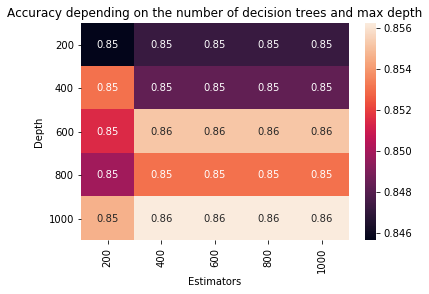

In [7]:
plot_grid_search_results(accuracy_mat, estimators, depth)

In [ ]:
max_num_est, max_num_depth, step = 300, 300, 10
estimators, depth = range(step,max_num_est,step), range(step,max_num_depth,step)

accuracy_scores, accuracy_mat = grid_search(estimators, depth, step, X_train, y_train, 
                                            X_valid, y_valid)


29it [15:20, 31.73s/it]
29it [12:38, 26.15s/it]
29it [13:18, 27.53s/it]
29it [18:05, 37.44s/it]
29it [21:04, 43.61s/it]
29it [25:21, 52.48s/it]
29it [29:59, 62.05s/it]
29it [34:25, 71.21s/it]
29it [37:55, 78.47s/it]
29it [42:30, 87.93s/it]
29it [46:35, 96.40s/it]
29it [51:25, 106.38s/it]
29it [54:35, 112.94s/it]
29it [59:45, 123.64s/it]
29it [1:03:44, 131.88s/it]
29it [1:42:50, 212.78s/it]
29it [1:54:10, 236.22s/it]
29it [1:21:07, 167.83s/it]
29it [1:28:52, 183.87s/it]
29it [1:40:18, 207.55s/it]
25it [1:22:00, 196.82s/it]

In [ ]:
opt_n_est,opt_max_depth = max(accuracy_scores, key=accuracy_scores.get)
rf = RandomForestClassifier(n_estimators=opt_n_est, max_depth = opt_max_depth,\
                            random_state = 0)
rf.fit(X_train, y_train)

predicted_train, train_accuracy = test_model(X_train, y_train, rf)
predicted_valid, valid_accuracy = test_model(X_valid, y_valid, rf)
predicted_test, test_accuracy = test_model(X_test, y_test, rf)

print("Training Accuracy : {}".format(train_accuracy))
print("Validation Accuracy : {}".format(valid_accuracy))
print("Testing Accuracy : {}".format(test_accuracy))


In [ ]:
y_est, test_accuracy = test_model(X_test, y_test, rf)
plt.figure(figsize = (12,12))
my_confusion_matrix(y_test, y_est, newsgroups['target_names'], print_cnf = False)


In [ ]:
num_relevant_features = np.count_nonzero(rf.feature_importances_)
prop_relevant_features = num_relevant_features/len(rf.feature_importances_)*100
print("Number of features with non zero importance {}".format(num_relevant_features))
print("Proportion of features with non zero importance : {:.1f} %".format(prop_relevant_features))
print("Highest importance obtained : {:.2f}%".format(max(rf.feature_importances_)*100))